# Association Analysis Project - Online Retail II

### What is association analysis?

Association analysis is an analysis that discovers the probability of different sets of items appearing in the same record. In simple terms, the analysis identifies products or items that frequently occur together. These relationships of co-occurence between items are expressed as __Association Rules__. An association rule might look like this: If items A and B are in a transaction or record, item C is likely to be there as well. These rules are often denoted as {antecedent} -> {consequent}. We will see more examples of this in the demonstration below.

<br>Association analysis, often referred to as __Market Basket Analyis__, is a valuable data mining technique. It can be especially valuable in settings like retail or food & beverage, where a business might want to know how different products relate to one another. Its strength lies in its ability to take in large amounts of customer data and to mine simple rules that are easily understood. 

<br>For example, Association Analysis can tell us how frequently __Product A__ and __Product B__ were purchased together. This information is then compared to the entire dataset to understand whether __Product A__ and __Product B's__ relationship is a meaningful opportunity for cross-selling, promotion, or another lever to drive sales. These rules are often expressed as {antecendent} -> {consequent}. In our case, {Product A} -> {Product B} or vice versa. A common way to say this notation is "Product A implies Product B." This exercise is then extended to all possible __itemsets__.

### Use Cases

- Recommender Systems
    - If customer bought Product A, recommend Product B
    - Frequently bought together, if user has Product A in cart, recommend Product B
- Cross-Selling or Up-Selling Opportunities in Retail
    - Cross-Selling:
    - Up-Selling:
- Promotion Opportunities
    - "Buy a pair of shoes, get a pair of socks for free"
    - "Buy a top in apparel, get a bottom in apparel for 50% off"

### Project Goal

In learning about association analysis, I found that most resources typically took input as a list of products and records: (A, B, C),(B,C),(A), etc. In my experience this is not a common format for transaction data.

Another limitation of existing demonstrations is that they typically present small datasets, no more than a few hundred rows. Again, in my experience, datasets are rarely that small in business. 

The goal of this project is to model an association analysis using large datasets (100,000+ records) and non-list formats of data input. 

This project is written in python, using popular data science libraries pandas, numpy, and mlxtend. 

### Project Outline

1. Read the dataset into python data structure (pandas dataframe)
1. Convert the data into the appropriate format for association analysis
1. Exploratory Analysis
1. Get Frequent Itemsets
1. Run Association Rules algorithm on Frequent Itemsets

### Data

The data for this project were obtained from the UC Irvine Machine Learning Repository. 

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license. This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

##### Citation
Chen,Daqing. (2019). Online Retail II. UCI Machine Learning Repository.<br>
https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii

### Import Libraries and Define Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

### Read Dataset(s) Into Dataframe

In [2]:
# the online retail data is housed in two different tabs, read both tabs
dataset = pd.read_excel(r'C:\Users\bwynd\OneDrive\Desktop\Data Analysis Portfolio\online_retail_data.xlsx',[0,1])

In [3]:
# concat the two sets into a single dataframe
df = pd.concat(dataset, ignore_index=True)

In [4]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,924,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,2824,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,2895,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,529,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,214,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,416,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,3218,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,3234,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,2352,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


### Cleaning the Data

Now that we have loaded the data, we will need to clean and transform the data in order to get the best results.

By calling df.info(), we can see in the Customer ID and Description columns we have a significant number of null rows. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  int64         
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 65.1+ MB


On closer inspection, we can see that the null values in Description are noise and can be dropped. The price is zero for all items and have no Customer ID.

It is not always a good practice to drop null records, sometimes it is better to impute, where null values are replaced with the mean, median, or mode. In this case, dropping null records is the better option.

In a true business setting, this noise in the dataset is important to understand. The wide range in Quantity is concerning and could impact metrics or reporting. This noise could be caused by errors in the data or processes that impact records in an unintended manner (inventory adjustments in/out, zero dollar sales, etc). 

Since we do not have the ability to investigate the causes behind this dataset, we will remove these rows.

In [6]:
na_desc = df[df['Description'].isna()]
na_desc.describe()

,StockCode,Quantity,Price,Customer ID
count,4382.000000,4382.000000,4382.0,0.0
mean,2793.217252,-17.262209,0.0,NaN
std,1543.331163,509.704959,0.0,NaN
min,3.000000,-9600.000000,0.0,NaN
25%,1486.250000,-28.000000,0.0,NaN
50%,2897.500000,-4.000000,0.0,NaN
75%,4242.000000,3.000000,0.0,NaN
max,5129.000000,9600.000000,0.0,NaN


In [7]:
# view of dataframe where description = NaN
na_desc

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,3996,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,4210,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,4213,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,4234,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,4043,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1060783,581199,960,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
1060787,581203,3702,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
1060793,581209,1155,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
1062442,581234,728,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


In [8]:
# dropping all null values in Description column
df.dropna(axis=0,subset=['Description'],inplace=True)

The null values in the Customer ID column are more challenging. There are negative, positive, and zero price values, so it is possible that there are real purchases worth exploring in this segment of the data. The transactions with values above 0 could be guest customer transactions. Since we do not need the Customer ID for our association analysis, it could be worth keeping some of this data. 

In this analysis, we are not concerned with negative quantities and records with a price of $0.00. These records indicate some other kind of transaction or record, not a customer purchase. 

With this decision on negative quantities and $0.00 products applying generally to the dataset, and not just Customer ID NaN rows, we will remove all rows in the dataframe that:
- have quantity <= 0
- have price <= 0.00

In [9]:
na_cust = df[df['Customer ID'].isna()]
na_cust.describe()

,StockCode,Quantity,Price,Customer ID
count,238625.000000,238625.000000,238625.000000,0.0
mean,1240.684312,1.885833,8.094711,NaN
std,1076.534535,71.946304,226.322727,NaN
min,1.000000,-9600.000000,-53594.360000,NaN
25%,374.000000,1.000000,1.660000,NaN
50%,954.000000,1.000000,3.360000,NaN
75%,1767.000000,2.000000,5.790000,NaN
max,5132.000000,10200.000000,25111.090000,NaN


In [10]:
na_cust

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,59,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,1142,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,1,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
577,489525,3327,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,1303,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1066997,581498,141,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066998,581498,61,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066999,581498,239,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
1067000,581498,1130,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [11]:
df.describe()

,StockCode,Quantity,Price,Customer ID
count,1.062989e+06,1.062989e+06,1.062989e+06,824364.000000
mean,1.229082e+03,1.005103e+01,4.668554e+00,15324.638504
std,1.143572e+03,1.699307e+02,1.238071e+02,1697.464450
min,1.000000e+00,-8.099500e+04,-5.359436e+04,12346.000000
25%,3.020000e+02,1.000000e+00,1.250000e+00,13975.000000
50%,8.540000e+02,3.000000e+00,2.100000e+00,15255.000000
75%,1.777000e+03,1.000000e+01,4.150000e+00,16797.000000
max,5.132000e+03,8.099500e+04,3.897000e+04,18287.000000


In [12]:
# removing all rows with quantity <= 0
df.drop(df[df['Quantity']<=0].index,inplace=True)

In [13]:
# removing all rows with price <= 0
df.drop(df[df['Price']<=0].index,inplace=True)

Now that we have removed the noise in the data, we can tell that our price and quantity columns have a more reasonable distribution of values.

In [14]:
df.describe()

,StockCode,Quantity,Price,Customer ID
count,1.041671e+06,1.041671e+06,1.041671e+06,805549.000000
mean,1.226034e+03,1.096345e+01,4.077038e+00,15331.954970
std,1.142089e+03,1.265149e+02,5.144898e+01,1696.737039
min,1.000000e+00,1.000000e+00,1.000000e-03,12346.000000
25%,3.020000e+02,1.000000e+00,1.250000e+00,13982.000000
50%,8.490000e+02,3.000000e+00,2.100000e+00,15271.000000
75%,1.768000e+03,1.000000e+01,4.130000e+00,16805.000000
max,5.132000e+03,8.099500e+04,2.511109e+04,18287.000000


We still have a difference in non-null values between Customer ID and the rest of the dataframe, but this will not matter for our analysis. Customer ID will be disregarded for the rest of the project.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041671 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1041671 non-null  object        
 1   StockCode    1041671 non-null  int64         
 2   Description  1041671 non-null  object        
 3   Quantity     1041671 non-null  int64         
 4   InvoiceDate  1041671 non-null  datetime64[ns]
 5   Price        1041671 non-null  float64       
 6   Customer ID  805549 non-null   float64       
 7   Country      1041671 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 71.5+ MB


### Preparing the Data

Now we will execute a few changes and transformations specific to the association analysis.

In [16]:
n_desc = df.Description.nunique()
n_stock_codes = df.StockCode.nunique()
n_inv = df.Invoice.nunique()

n_desc,n_stock_codes,n_inv

(5399, 4746, 40078)

In [17]:
# in order to convert the data to a sparse matrix, 
# we will need to convert description and invoice columns to numeric ids
df['product_id'] = df.groupby(['StockCode']).ngroup()
df['invoice_id'] = df.groupby(['Invoice']).ngroup()

In [18]:
# added two columns to end
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,product_id,invoice_id
0,489434,924,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,923,0
1,489434,2824,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2823,0
2,489434,2895,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2894,0
3,489434,529,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,528,0
4,489434,214,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,213,0
...,...,...,...,...,...,...,...,...,...,...
1067366,581587,416,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,415,40075
1067367,581587,3218,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,3211,40075
1067368,581587,3234,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,3227,40075
1067369,581587,2352,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2351,40075


In [19]:
# transform the dataset into a sparse matrix
# rows: invoice, columns: products, values: quantity
from scipy.sparse import csr_matrix

inv_item_matrix = csr_matrix((df['Quantity'].astype(float), (df['invoice_id'], df['product_id'])))

In [20]:
inv_item_matrix

<40078x4746 sparse matrix of type '<class 'numpy.float64'>'
	with 996546 stored elements in Compressed Sparse Row format>

After converting the csr matrix back to a pandas dataframe for ease of visualization, we have our invoice X product matrix.

In [21]:
# convert matrix to pd dataframe
mat_df = pd.DataFrame.sparse.from_spmatrix(inv_item_matrix)
mat_df

,0,1,2,3,4,5,6,7,8,9,...,4736,4737,4738,4739,4740,4741,4742,4743,4744,4745
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will also add back in the descriptions to our columns.

In [22]:
# creating a distilled version of the dataframe with only what is needed
product_desc_lookup = df[['product_id','Description']]
product_desc_lookup = product_desc_lookup.drop_duplicates(subset=['product_id'])

In [23]:
# sorting by product_ids, setting product_ids as index
product_desc_lookup.sort_values(by=['product_id'],inplace=True)
product_desc_lookup.set_index('product_id',inplace=True)

In [24]:
# convert dataframe to dictionary
# get inside of dictionary to pass into rename
p_dict = product_desc_lookup.to_dict()
p_dict = p_dict['Description']

In [25]:
# rename df column names based on product_id-description mapping
mat_df.rename(columns=p_dict,inplace=True)
mat_df

,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,JAM MAKING SET WITH JARS,...,BLUE/PINK NEST STRIPE BOX,Adjustment by Peter on Jun 25 2010,SET/3 FLORAL GARDEN TOOLS IN BAG,FOLDING SHIRT TIDY,WOOD XMAS TREE 9 FIG SHELVES,KID'S CHALKBOARD/EASEL,"MIRROR, ARCHED GEORGIAN",BREAD BIN DINER STYLE BLACK,ROSE PINK PENDANT SHELL NECKLACE,IVORY PENDANT SHELL NECKLACE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploring the Data

Before converting the data to Boolean format for our Association Analysis, let's explore the data.

In [26]:
# min max of products - understanding the high and low of product appearances in dataset
n_purchases_per_product = inv_item_matrix.getnnz(axis=1)

print(f"Most purchased product has {n_purchases_per_product.max()} purchases.")
print(f"Least purchased product has {n_purchases_per_product.min()} purchases.")

Most purchased product has 1108 purchases.
Least purchased product has 1 purchases.


In [27]:
# min max of invoices - understanding the high and low of invoices

n_products_per_invoice = inv_item_matrix.getnnz(axis=0)

print(f"The largest invoice has {n_products_per_invoice.max()} products on it.")
print(f"The smallest invoice has {n_products_per_invoice.min()} products on it.")

The largest invoice has 5464 products on it.
The smallest invoice has 1 products on it.


#### Sparsity

Transaction - Item Matrices are typically very sparse, meaning that most of the values in the matrix are null or zero. The null or zero value indicates that the product was not present in that transaction. We will touch more on sparsity in the conclusion section.

In [28]:
# measuring sparsity of item - user matrix
n_total = inv_item_matrix.shape[0]*inv_item_matrix.shape[1]
n_purchases = inv_item_matrix.nnz
sparsity = n_purchases/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.52%


#### Visualizing the Distribution

C:\Users\bwynd\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\bwynd\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


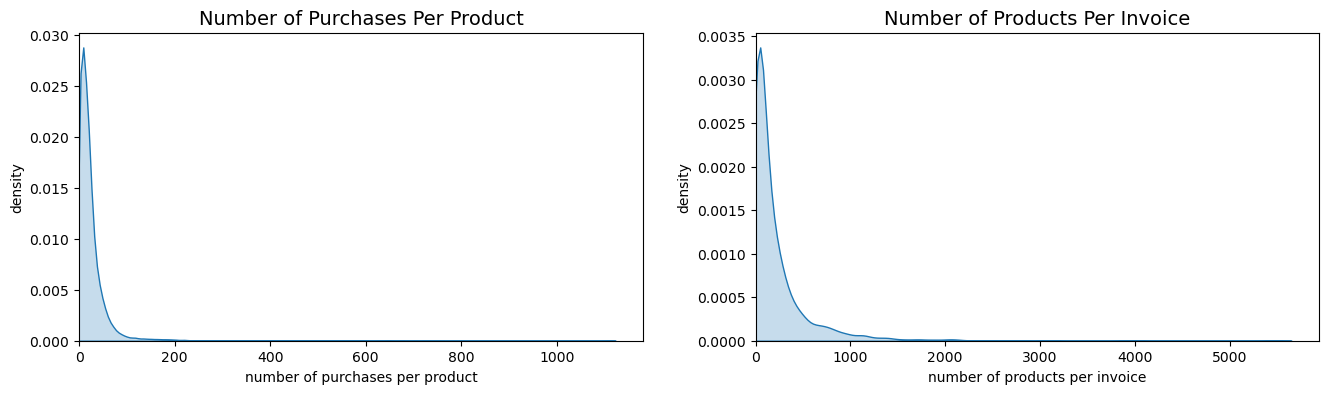

In [29]:
import seaborn as sns
from seaborn import kdeplot

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_purchases_per_product, shade=True)
plt.xlim(0)
plt.title("Number of Purchases Per Product", fontsize=14)
plt.xlabel("number of purchases per product")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_products_per_invoice, shade=True)
plt.xlim(0)
plt.title("Number of Products Per Invoice", fontsize=14)
plt.xlabel("number of products per invoice")
plt.ylabel("density")
plt.show()

### Convert Dataframe to Boolean Format

Now that we understand the distribution of the data a little better. We can take the final steps of preparing the data before running the analysis.

We are going to convert the values in the Transaction x Product matrix from quantities into Present/Not-Present values. This will be a Boolean (True/False) formatting.

We are not concerned with quantity purchased in the association analysis, just co-occurence of items in the same transaction.

In [30]:
sdf = mat_df.astype(pd.SparseDtype("bool", False))

In [31]:
sdf

,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,JAM MAKING SET WITH JARS,...,BLUE/PINK NEST STRIPE BOX,Adjustment by Peter on Jun 25 2010,SET/3 FLORAL GARDEN TOOLS IN BAG,FOLDING SHIRT TIDY,WOOD XMAS TREE 9 FIG SHELVES,KID'S CHALKBOARD/EASEL,"MIRROR, ARCHED GEORGIAN",BREAD BIN DINER STYLE BLACK,ROSE PINK PENDANT SHELL NECKLACE,IVORY PENDANT SHELL NECKLACE
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40073,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40074,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40075,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40076,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
sdf.describe()

,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,JAM MAKING SET WITH JARS,...,BLUE/PINK NEST STRIPE BOX,Adjustment by Peter on Jun 25 2010,SET/3 FLORAL GARDEN TOOLS IN BAG,FOLDING SHIRT TIDY,WOOD XMAS TREE 9 FIG SHELVES,KID'S CHALKBOARD/EASEL,"MIRROR, ARCHED GEORGIAN",BREAD BIN DINER STYLE BLACK,ROSE PINK PENDANT SHELL NECKLACE,IVORY PENDANT SHELL NECKLACE
count,40078,40078,40078,40078,40078,40078,40078,40078,40078,40078,...,40078,40078,40078,40078,40078,40078,40078,40078,40078,40078
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,34614,39351,39235,39069,38933,39386,39785,39220,39299,38919,...,40073,40075,40077,40077,40074,40076,40077,40077,40077,40077


In [33]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40078 entries, 0 to 40077
Columns: 4746 entries, WHITE HANGING HEART T-LIGHT HOLDER to IVORY PENDANT SHELL NECKLACE
dtypes: Sparse[bool, False](4746)
memory usage: 4.8 MB


### Association Analysis

#### Key Terms
Support
- how frequently the itemset occurs in the dataset
- for association rules, the closer the support is to 1, the more prevalent the itemset

Confidence
- the conditional probability of the consequent given the antecent
- product a implies product b with X% confidence
- a confidence of 1 or 100% is perfect confidence, meaning that the itemsets appeared together in every transaction

Lift
- strength of the rule over random co-occurence
- factors in the individual support of the antecedent and consequent
- measures the increase in probability of the consequent given the antecedent
- any value above 1 is meaningful
- if lift < 1, the rule is no better than random

### Get Frequent Itemsets Using FPGrowth Algorithm

Now that we have cleaned our original data and transformed it into a True/False Transaction X Product Matrix, we are ready for the actual data mining.

First we will identify frequent itemsets using the FPGrowth Algorithm from the mlxtend library.

FPGrowth is a computationally efficient alternative to the Apriori algorithm. It utilizes a Frequent Pattern tree datastructure without generating the candidates explicitly. This is advantageous when working with large datasets. This algorithm also reduces the number of iterations through the dataset compared to Apriori.

Because our matrix is very sparse, with a sparsity of 0.52%, we will set our minimum support to 0.01. This is roughly 400 records where the itemset is present.

In [34]:
frequent_itemsets = fpgrowth(sdf, min_support=0.01, use_colnames=True)

In [35]:
frequent_itemsets

,support,itemsets
0,0.060757,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.027995,(FANCY FONT HOME SWEET HOME DOORMAT)
2,0.019437,(SAVE THE PLANET MUG)
3,0.017291,(PINK DOUGHNUT TRINKET POT )
4,0.013848,"(RECORD FRAME 7"" SINGLE SIZE )"
...,...,...
1350,0.010130,"(JUMBO BAG APPLES, JUMBO BAG PEARS)"
1351,0.014397,"(JUMBO BAG DOILEY PATTERNS, JUMBO BAG RED WHIT..."
1352,0.012575,"(LUNCH BAG DOILEY PATTERN , JUMBO BAG DOILEY P..."
1353,0.011528,"(LUNCH BAG DOILEY PATTERN , LUNCH BAG RED SPOTTY)"


### Get Association Rules from Frequent Itemsets

After discovering the frequent itemsets with a support/frequency of at least 0.01, we can use this list to mine association rules. 

For this, we will set the minimum confidence to 0.5, which is the threshold for random present/not-present. 

As a refresher, confidence measures the conditional probability of the consequent(s) given the antecedent(s). In short, what is the __new__ probability of B, if A is present. 

In [36]:
association_rule_list = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

In [37]:
association_rule_list.sort_values('confidence',ascending=False,inplace=True)

In [38]:
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',None)

display(association_rule_list)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
406,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",(GREEN REGENCY TEACUP AND SAUCER),0.011702,0.033759,0.010754,0.918977,27.221539,0.010359,11.925446
394,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",(GREEN REGENCY TEACUP AND SAUCER),0.020260,0.033759,0.018339,0.905172,26.812639,0.017655,10.189449
283,"(CHARLOTTE BAG , PINK/WHITE SPOTS, WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE BAG)",(RED SPOTTY CHARLOTTE BAG),0.011677,0.050776,0.010554,0.903846,17.800662,0.009961,9.871930
399,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER)",(GREEN REGENCY TEACUP AND SAUCER),0.013823,0.033759,0.012351,0.893502,26.466937,0.011884,9.072838
298,"(CHARLOTTE BAG , PINK/WHITE SPOTS, CHARLOTTE BAG , SUKI DESIGN, STRAWBERRY CHARLOTTE BAG)",(RED SPOTTY CHARLOTTE BAG),0.012501,0.050776,0.011103,0.888224,17.492985,0.010469,8.492165
438,"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM )",(POPPY'S PLAYHOUSE KITCHEN),0.011503,0.018514,0.010205,0.887202,47.920851,0.009992,8.701252
180,"(SET/20 RED SPOTTY PAPER NAPKINS , SET/6 RED SPOTTY PAPER CUPS)",(SET/6 RED SPOTTY PAPER PLATES),0.013898,0.024552,0.012101,0.870736,35.464798,0.011760,7.546173
405,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER ),0.012351,0.035531,0.010754,0.870707,24.505757,0.010315,7.459567
439,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOUSE KITCHEN)",(POPPY'S PLAYHOUSE BEDROOM ),0.011827,0.017541,0.010205,0.862869,49.192136,0.009998,7.164395
393,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER ),0.021558,0.035531,0.018339,0.850694,23.942508,0.017573,6.459701


Let's breakdown an association rule. 

__{Regency Cakestand 3 Tier, Roses Regency Teacup and Saucer, Pink Regency Teacup and Saucer} --> {Green Regency Teacup and Saucer}__
- Support of 0.01075 - this pattern appeared in roughly 430 transactions
- Confidence of 0.92 - when the antecedent was present, the customer almost always purchased the green teacup as well
- Lift of 27 - customers are 27 times more likely than random chance to purchase the green teacup if all else are present

### Considerations

430 transactions out of the 40,000 total in this dataset is not a huge portion of the transactions. So one individual association rule will have a limited impact on the total business. 

However, in aggregate, these rules can capitalize on hidden patterns and relationships between products. Implementing strategies or changes that utilize these rules can amplify these relationships, leading to higher Units per Transaction and overall revenue for a retail business.

### Opportunities for Further Analysis

In our exploratory analysis of the data, there are areas that could be explored further. 
- Removing clear outliers in the data (ex: customers with thousands of purchases or invoices with thousands of products)
- Filtering by country before running the analyses
- Filtering or separating the data by year or season

### Conclusion

Association Rules -- when used with sound data, efficient and effective algorithms, and implemented in ensemble -- can  be a valuable tool for businesses to understand their customers better. These rules can be used to present recommendations or add-ons to a user, or they can be used to determine effective promotion opportunities or cross-merchandising possibilities. 

In order for a rule to valuable, it must have sufficient support (frequency of co-occurence in the data set), confidence (conditional probability of B given A), and lift (the increase in probability of the consequent given the antecedent).

Thank you for taking the time to view this project. I hope it was valuable and clear in explanation. If you have any questions, please feel free to reach out on LinkedIn or my website below. 

If you have any feedback, I would happy to hear it! I am always looking to learn more in the field of data and data science. 

#### Check out more of my data analysis projects and work at:

__Website__ https://benjaminwyndham.com/

__LinkedIn__ https://www.linkedin.com/in/benwyndham/

__GitHub__ https://github.com/bwyndham